In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from datetime import datetime
import os 

# key: age group for scenario, 
# value: dictionary with corresponding groups in the dataset 
# and factor to convert to scenario age groups (i.e., 0-2 mo are 1/4 of the <1 year)
age_groups = {'0-2 mo': {"groups": ['Less than 1 year']},
              '3-5 mo': {"groups": ['Less than 1 year']},
              '6-11 mo': {"groups": ['Less than 1 year']},
              '12-35 mo': {"groups": ['1 year', '2 years']}, 
              '36-59 mo': {"groups": ['3 years', '4 years']},
              '5-17 y': {"groups": [f"{i} years" for i in np.arange(5, 18)]},
              '18-64 y': {"groups": [f"{i} years" for i in np.arange(18, 65)]},
              '65-74 y': {"groups": [f"{i} years" for i in np.arange(65, 75)]},
              '75-84 y': {"groups": [f"{i} years" for i in np.arange(75, 85)]},
              '≥85 y': {"groups": [f"{i} years" for i in np.arange(85, 100)] + ['Open-ended age class']}}

months_check = {"0-2 mo": 3, "3-5 mo": 3, "6-11 mo": 6}


def import_births(country): 
    """
    Import births data for a given country
    """
    # import births 
    if os.path.exists("../births/births_by_month.csv"):
        births = pd.read_csv("../births/births_by_month.csv")
        births = births[births.country == country]
        # create a date column for easier manipulation
        births["date"] = pd.to_datetime([datetime.strptime(f"{yr}-{mt}-01", "%Y-%B-%d") for yr, mt in zip(births.year, births.month)])
    else: 
        raise FileNotFoundError("births_by_month.csv not found, run births/parse_eurostat_births.ipynb first")
    return births


def compute_population_1yr_share(country, scenario_start_date): 
    """
    Compute the share of population in each <1yr sub-group for a given country and scenario start date
    """

    population_1yr = {"0-2 mo": 0, "3-5 mo": 0, "6-11 mo": 0}
    population_1yr_share = {"0-2 mo": 0, "3-5 mo": 0, "6-11 mo": 0}
    scenario_start_date = pd.to_datetime(scenario_start_date)

    # import births 
    births = import_births(country)

    for grp in population_1yr: 
        # get start and end extremes of the age group
        start, end = int(grp.split("-")[0]), int(grp.split("-")[1].replace(" mo", ""))

        # get start and end dates for births
        start_date = scenario_start_date - pd.DateOffset(months=end+1)
        end_date = scenario_start_date - pd.DateOffset(months=start)

        # get births that contribute to the population in the given age group
        births_grp = births[(births.date >= start_date) & (births.date < end_date)]
        if births_grp.shape[0] !=  months_check[grp]:
            print(f"{country} {grp} has {births_grp.shape[0]} births, expected {months_check[grp]}")

        population_1yr[grp] = births_grp.births.sum()

    # compute share of population in each <1yr sub-group
    for grp in population_1yr: 
        population_1yr_share[grp] = population_1yr[grp] / sum(population_1yr.values())

    return population_1yr_share

    
def get_population_data(df, country, year=2023, scenario_start_date="2023-09-01"): 
    """
    Get population data for a given country and year and convert to scenario age groups
    """

    # name mismatch between RESCEU and EUROSTAT
    if country == "Czech Republic":
        country = "Czechia"
        
    # get data for country and year
    df_country_year = df[(df.geo == country) & (df.TIME_PERIOD == year)] 

    # get the share of population in each <1yr sub-group
    population_1yr_share = compute_population_1yr_share(country, scenario_start_date)

    # check if location is in UN data
    if len(df_country_year) == 0:
        print(f"{country} not found in EUROSTAT data")
        return pd.DataFrame()
    
    # convert to scenario age groups
    Nk, Nk_names = [], []
    for grp in age_groups: 
        df_location_grp = df_country_year[df_country_year.age.isin(age_groups[grp]["groups"])]
        if grp in population_1yr_share:
            Nk.append(int(df_location_grp.OBS_VALUE.values.sum() * population_1yr_share[grp]))
        else:
            Nk.append(int(df_location_grp.OBS_VALUE.values.sum()))
        Nk_names.append(grp)
    
    df_final = pd.DataFrame({"group_name": Nk_names, "population": Nk})
    df_final["country"] = country
    df_final["year"] = year
    return df_final

Note on the open-ended age class:
(https://ec.europa.eu/eurostat/cache/metadata/en/demo_pop_esms.htm#shortdata_descrDisseminated)

"Open-ended age class concept (Y_OPEN code) is a solution for presenting different open-ended age classes for data on population that are reported by the countries.
The open-ended age classes for data on population are the following: 85 and over (+), 90+, 95+, 99+, 100+ with the exceptions:
- Bulgaria: 80+ for the years 1994, 1995 and 1996
- Cyprus: 80+ for the years 1990, 1991 and 1992
- Turkey: 75+ for the years 2009, 2010 and 2011

Open-ended age class contains all the people aged more than the last single age for which a country can report. For example, if a country can provide data on its population by single year of age up to 94 years old, the ''open ended age class'' contains population 95 years old and over."


In [2]:
# get list of countries in RESCEU data
countries = pd.read_csv("../hospitalization_rates/RESCEU_total_hosp_rates.csv").country.unique()
print(countries)

['Austria' 'Belgium' 'Bulgaria' 'Croatia' 'Cyprus' 'Czech Republic'
 'Denmark' 'Estonia' 'Finland' 'France' 'Germany' 'Greece' 'Hungary'
 'Ireland' 'Italy' 'Latvia' 'Lithuania' 'Luxembourg' 'Malta' 'Netherlands'
 'Norway' 'Poland' 'Portugal' 'Romania' 'Slovakia' 'Slovenia' 'Spain'
 'Sweden' 'United Kingdom']


In [3]:
# import EUROSTAT population data
df = pd.read_csv("./raw-data/estat_demo_pjan_filtered_en.csv")
df.head()

,DATAFLOW,LAST UPDATE,freq,unit,age,sex,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG,CONF_STATUS
0,ESTAT:DEMO_PJAN(1.0),23/05/25 23:00:00,Annual,Number,Total,Total,Andorra,2019,76177.0,NaN,NaN
1,ESTAT:DEMO_PJAN(1.0),23/05/25 23:00:00,Annual,Number,Total,Total,Albania,2015,2885796.0,NaN,NaN
2,ESTAT:DEMO_PJAN(1.0),23/05/25 23:00:00,Annual,Number,Total,Total,Albania,2016,2875592.0,NaN,NaN
3,ESTAT:DEMO_PJAN(1.0),23/05/25 23:00:00,Annual,Number,Total,Total,Albania,2017,2876591.0,NaN,NaN
4,ESTAT:DEMO_PJAN(1.0),23/05/25 23:00:00,Annual,Number,Total,Total,Albania,2018,2870324.0,NaN,NaN


In [4]:
# get population data for each country (year 2023 to match births data)
df_total = pd.DataFrame() 
for location in countries:
    for year in np.arange(2022, 2025): 
        df_country = get_population_data(df, location, year=year)
        df_total = pd.concat([df_total, df_country], ignore_index=True)
df_total.head()

United Kingdom 0-2 mo has 0 births, expected 3
United Kingdom 3-5 mo has 0 births, expected 3
United Kingdom 6-11 mo has 0 births, expected 6
United Kingdom not found in EUROSTAT data
United Kingdom 0-2 mo has 0 births, expected 3
United Kingdom 3-5 mo has 0 births, expected 3
United Kingdom 6-11 mo has 0 births, expected 6
United Kingdom not found in EUROSTAT data
United Kingdom 0-2 mo has 0 births, expected 3
United Kingdom 3-5 mo has 0 births, expected 3
United Kingdom 6-11 mo has 0 births, expected 6
United Kingdom not found in EUROSTAT data


/var/folders/5q/w1ww7ss174bb2jxkr7jkj3rw0000gp/T/ipykernel_8517/1688136137.py:68: RuntimeWarning: invalid value encountered in scalar divide
  population_1yr_share[grp] = population_1yr[grp] / sum(population_1yr.values())
/var/folders/5q/w1ww7ss174bb2jxkr7jkj3rw0000gp/T/ipykernel_8517/1688136137.py:68: RuntimeWarning: invalid value encountered in scalar divide
  population_1yr_share[grp] = population_1yr[grp] / sum(population_1yr.values())
/var/folders/5q/w1ww7ss174bb2jxkr7jkj3rw0000gp/T/ipykernel_8517/1688136137.py:68: RuntimeWarning: invalid value encountered in scalar divide
  population_1yr_share[grp] = population_1yr[grp] / sum(population_1yr.values())


,group_name,population,country,year
0,0-2 mo,21692,Austria,2022
1,3-5 mo,20371,Austria,2022
2,6-11 mo,42487,Austria,2022
3,12-35 mo,170138,Austria,2022
4,36-59 mo,177096,Austria,2022


In [5]:
# save to csv
df_total.to_csv("./population_estimates.csv", index=False)

In [7]:
# do some checks on total population
for country in df_total.country.unique():
    df_country = df_total[(df_total.country == country) & (df_total.year == 2023)]
    print(f"{country}: {df_country.population.sum()/1e6:.2f} M")

Austria: 9.10 M
Belgium: 11.74 M
Bulgaria: 6.45 M
Croatia: 3.85 M
Cyprus: 0.95 M
Czechia: 10.83 M
Denmark: 5.93 M
Estonia: 1.37 M
Finland: 5.56 M
France: 68.28 M
Germany: 83.12 M
Greece: 10.41 M
Hungary: 9.60 M
Ireland: 5.27 M
Italy: 59.00 M
Latvia: 1.88 M
Lithuania: 2.86 M
Luxembourg: 0.66 M
Malta: 0.54 M
Netherlands: 17.81 M
Norway: 5.49 M
Poland: 36.75 M
Portugal: 10.52 M
Romania: 19.05 M
Slovakia: 5.43 M
Slovenia: 2.12 M
Spain: 48.09 M
Sweden: 10.52 M


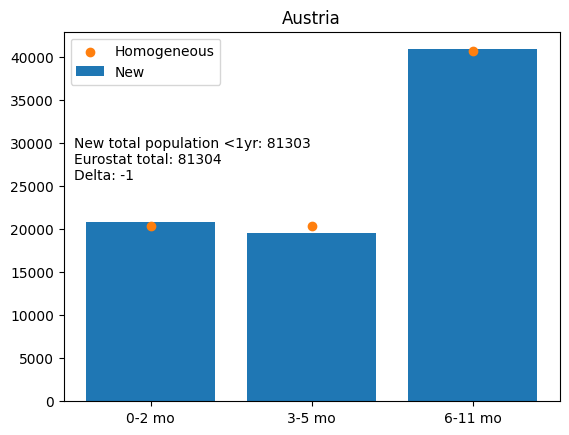

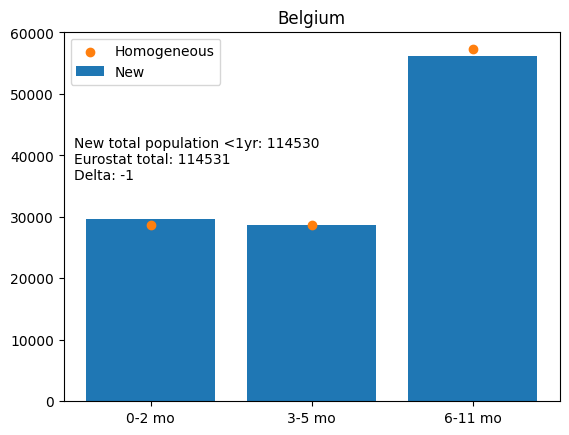

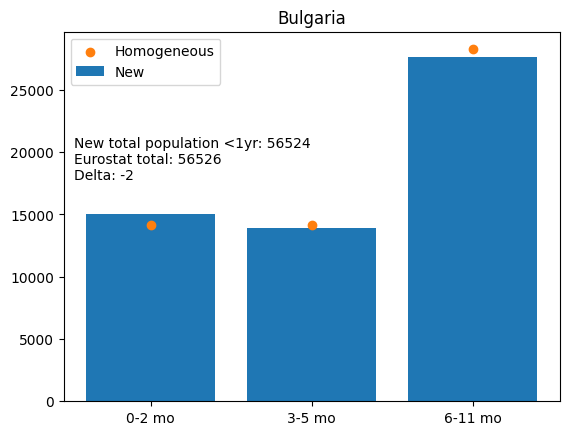

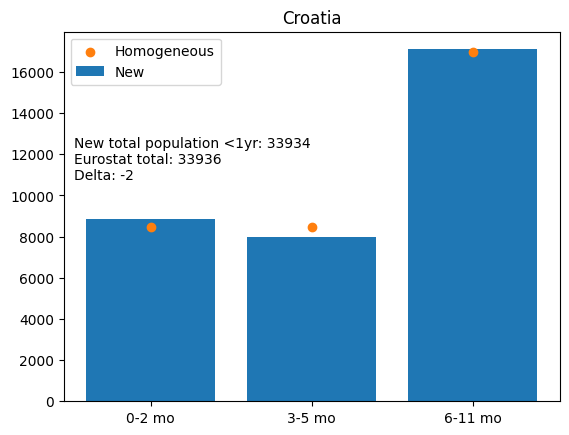

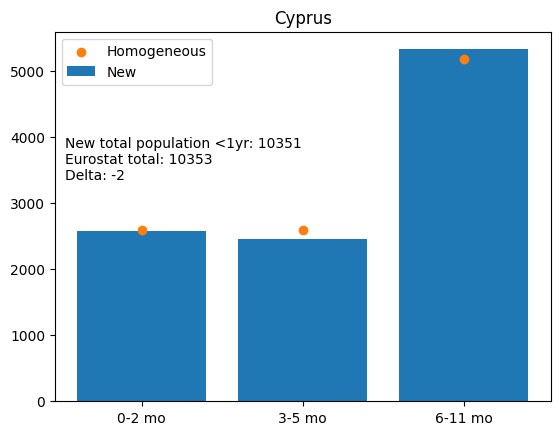

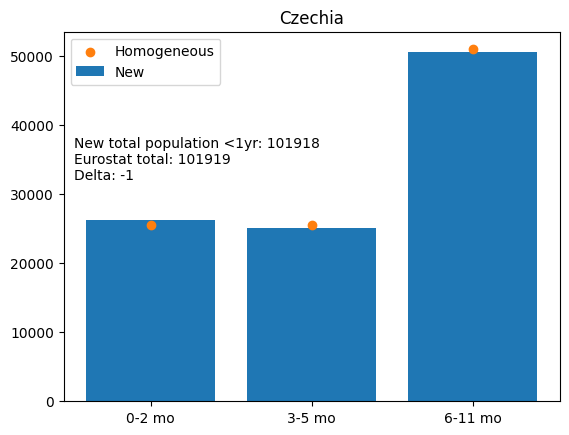

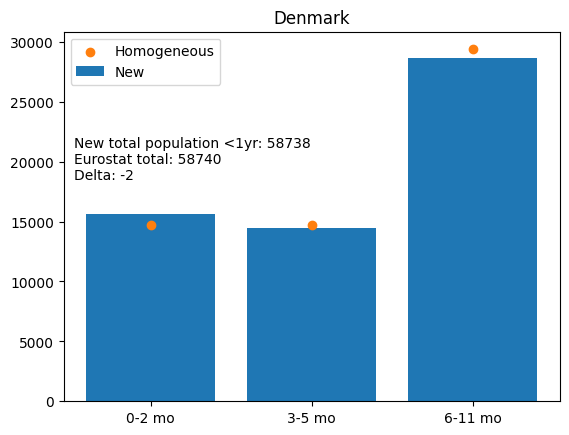

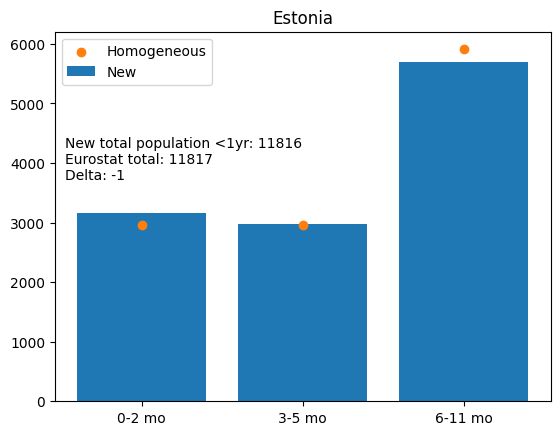

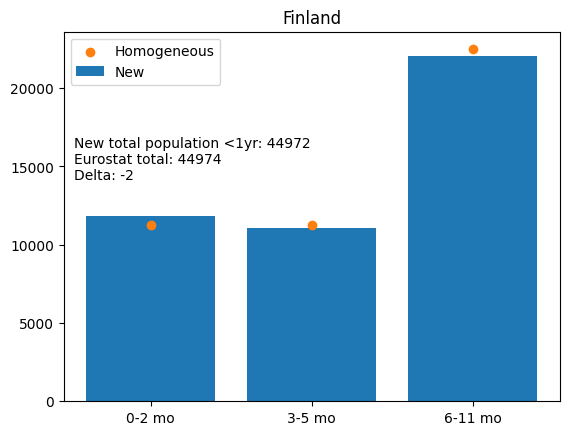

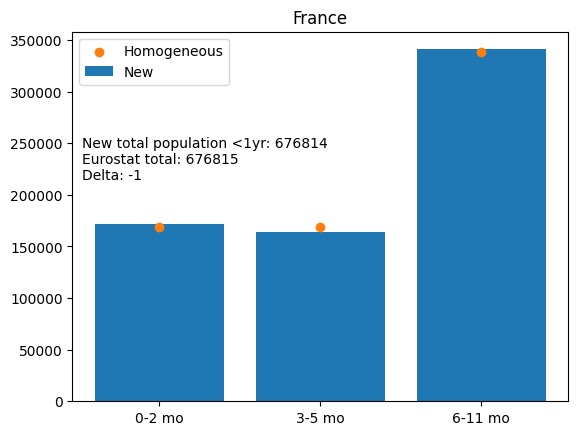

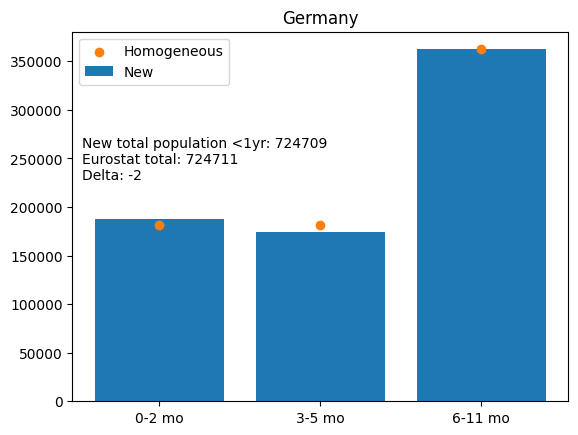

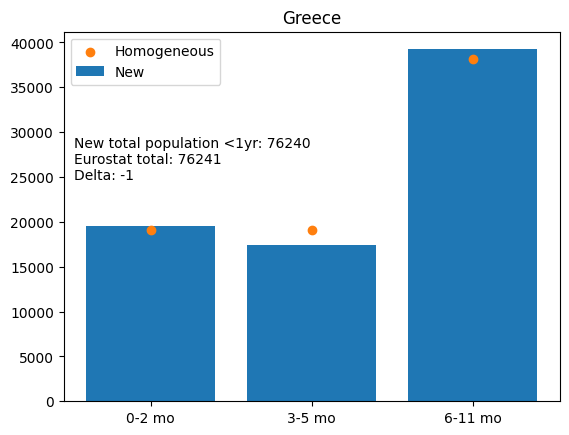

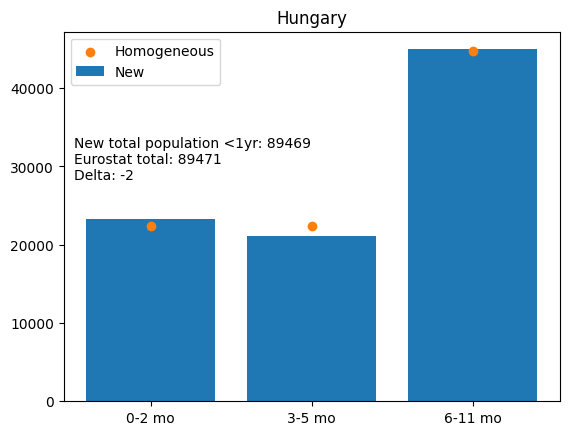

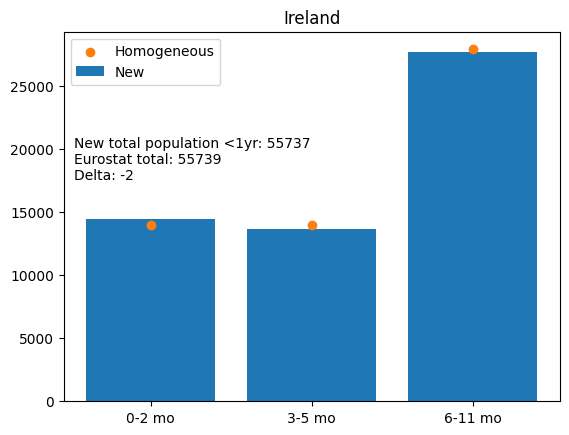

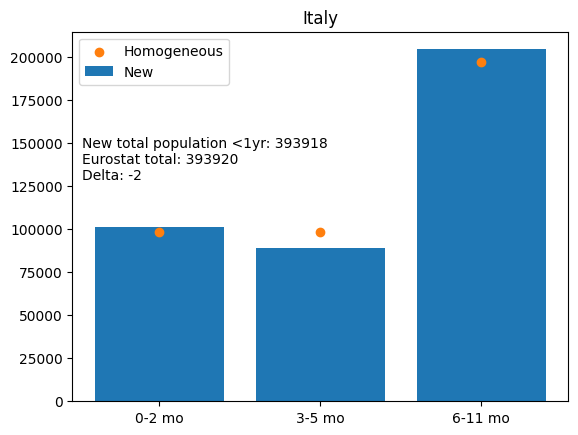

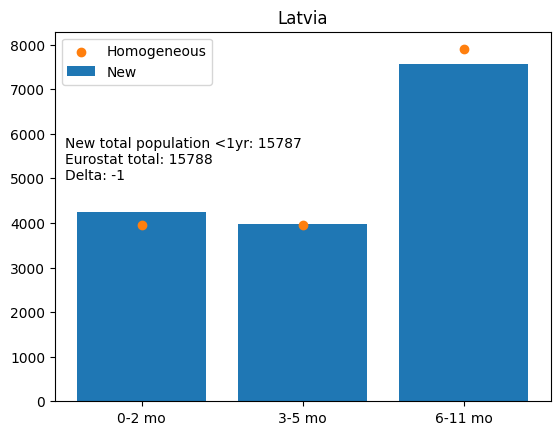

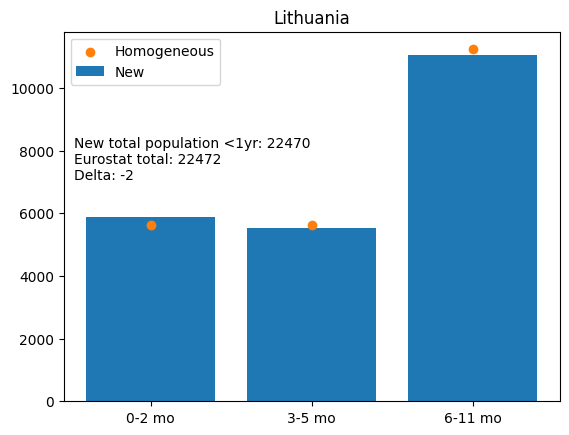

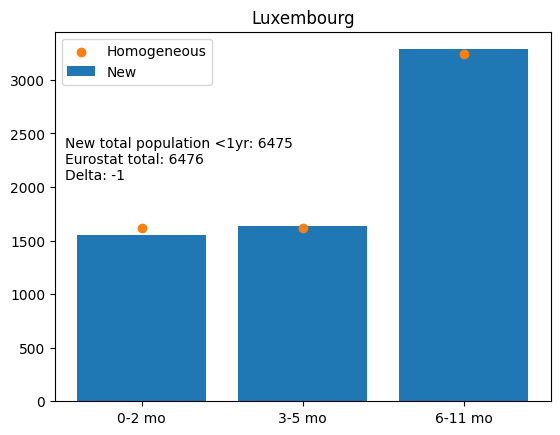

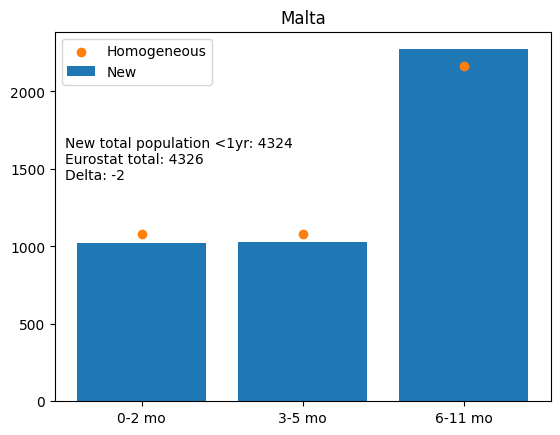

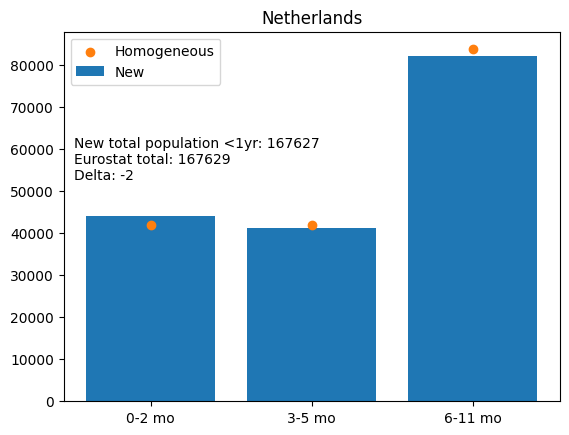

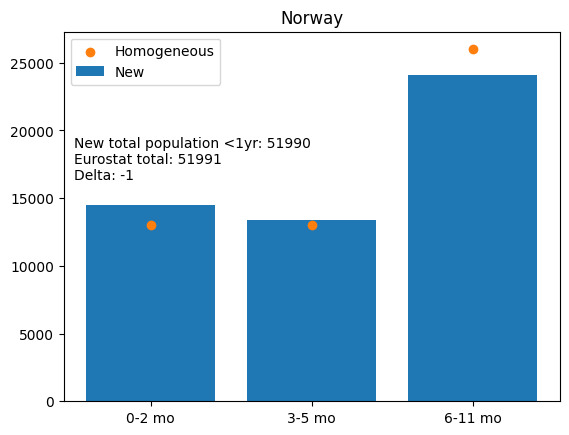

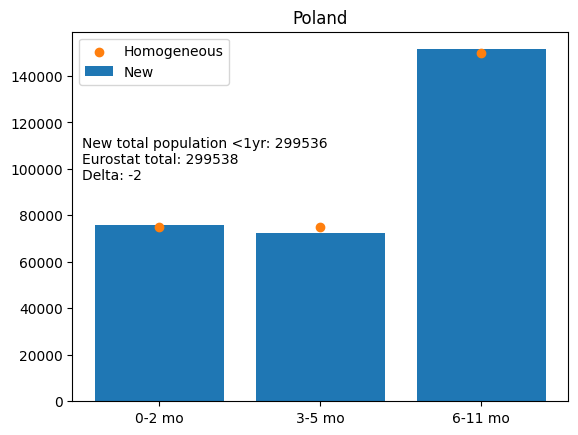

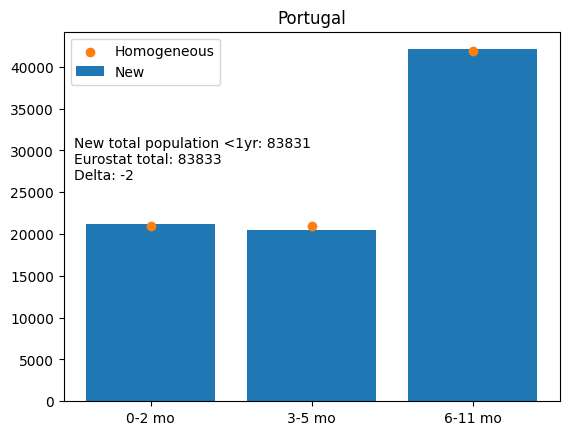

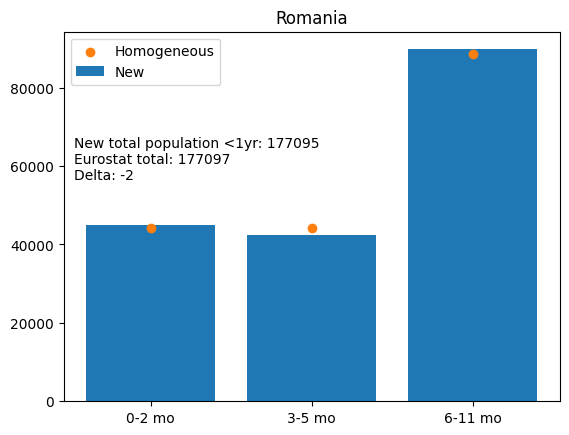

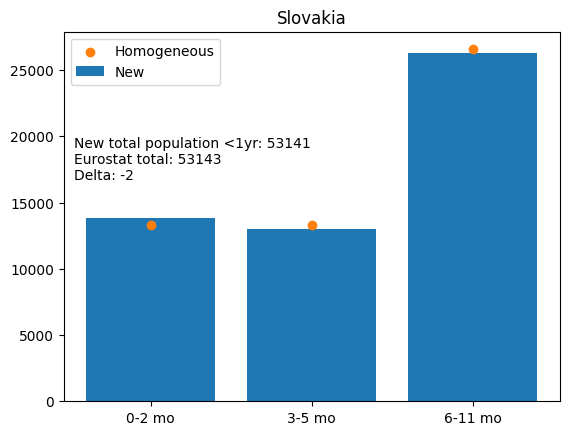

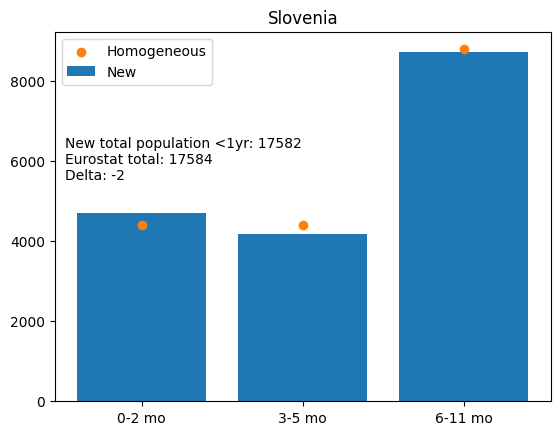

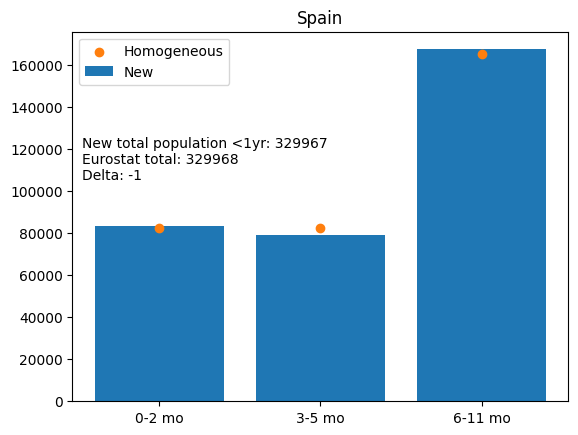

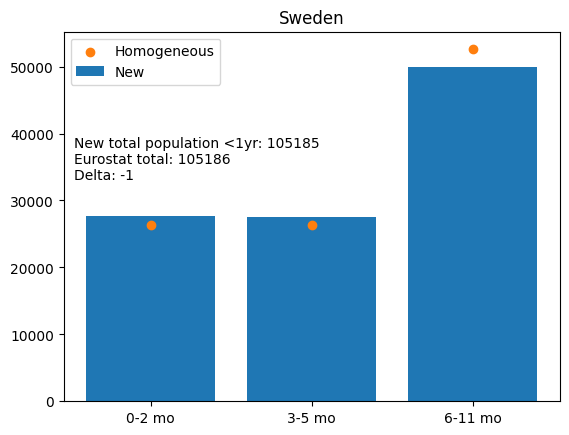

In [9]:
## checks on the share of population in each <1yr sub-group
for country in df_total.country.unique():

    # get results for novel computation
    df_country = df_total[(df_total.country == country) & (df_total.year == 2023)]
    subgroups_1yr = df_country.loc[df_country.group_name.isin(["0-2 mo", "3-5 mo", "6-11 mo"])].population.values
    total_population_1yr = np.sum(subgroups_1yr)

    # check we match eurostat total and compare with homogeneous computation
    total_poulation_1yr_eurostat = df[(df.geo == country) & (df.TIME_PERIOD == 2023) & (df.age == "Less than 1 year")].OBS_VALUE.values[0]
    subgroups_1yr_homogeneous = total_poulation_1yr_eurostat * np.array([1./4., 1./4., 1./2.])

    # delta between new and homogeneous
    delta = total_population_1yr - total_poulation_1yr_eurostat

    # plot
    plt.bar(['0-2 mo', '3-5 mo', '6-11 mo'], subgroups_1yr, label='New')
    plt.scatter(['0-2 mo', '3-5 mo', '6-11 mo'], subgroups_1yr_homogeneous, label='Homogeneous')
    plt.annotate(f"New total population <1yr: {total_population_1yr:.0f}\nEurostat total: {total_poulation_1yr_eurostat:.0f}\nDelta: {delta:.0f}", xy=(0.02, 0.6), xycoords='axes fraction')
    plt.title(country)
    plt.legend(loc="upper left")
    plt.show()